In [93]:
import numpy as np
import pandas as pd
from numpy.random import randn
np.random.seed(101)
DATA_DIR = '/Users/nathanzhao/Desktop/Python_quant_finance' + \
        '/Python-for-Finance-Repo-master-master' + \
        '/08-Time-Series-Analysis' 
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
%matplotlib inline

# Catalog:
* ### StatsModels
* ### EWMA
* ### ETS
* ### ARIMA (not suit for financial data)

================================================
================================================

# StatsModels
* Get data & toggle
* Hodrick-Prescott filter

### Get data & toggle

In [95]:
# SM comes with some datasets
df = sm.datasets.macrodata     .load_pandas().data
    # AND
    # print(sm.datasets.macrodata.NOTE)
    
# Set 'year' to index
    # df.set_index('year', inplace = True)
    # OR
index = pd.Index(   sm.tsa  .datetools.dates_from_range  ('1959Q1','2009Q3'))
df.index = index

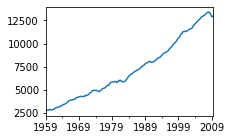

In [96]:
df['realgdp'].plot(figsize = (3,2))

### Hodrick-Prescott filter: 
* ###### The Hodrick-Prescott filter separates a time-series  y_t  into a trend  τ_t and a cyclical component  ζt

###### $y_t = \tau_t + \zeta_t$

* ###### The components are determined by minimizing the following quadratic loss function

###### $\min_{\\{ \tau_{t}\\} }\sum_{t}^{T}\zeta_{t}^{2}+\lambda\sum_{t=1}^{T}\left[\left(\tau_{t}-\tau_{t-1}\right)-\left(\tau_{t-1}-\tau_{t-2}\right)\right]^{2}$
* Returns tuple: cycle & trend

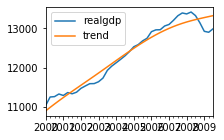

In [97]:
result = sm.tsa.filters.hpfilter(df['realgdp'])
type(result) # ===> tuple

gdp_cycle, gdp_trend = result

df['trend'] = gdp_trend 
df[['realgdp', 'trend']].loc['2000-03-31':].plot(figsize = (3,2))

-------------
-------------

# EWMA: Exponentially Weighted Moving Averages
* "EWM" Arguments: adjust, {com, span, halflife}

### Note: Improved upon SMA: Simple Moving Average, which
* smaller windows lead to more noise than signal
* always lag by size of window => have missing data at the first point
* never reach the full peak or valley of data due to averaging
* does not inform future behaviour, all it does is describe trend
* extreme historical value can skew it significantly
    

In [106]:
airline = pd.read_csv(DATA_DIR + '/airline_passengers.csv', index_col = 'Month')
# Recall: airline.info()

print(airline.isna().values.sum(axis=0))
airline.dropna(inplace = True)
airline.index = pd.to_datetime(airline.index)

[1]


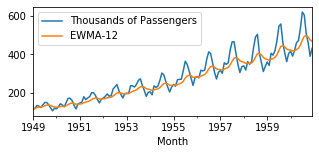

In [107]:
# EWMA
airline['EWMA-12'] = airline['Thousands of Passengers'].ewm(span = 12).mean()

airline[['Thousands of Passengers', 'EWMA-12']].plot(figsize = (5,2))

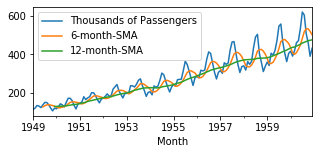

In [108]:
# VS: SMA
airline['6-month-SMA'] = airline['Thousands of Passengers'].rolling(window = 6).mean()
airline['12-month-SMA'] = airline['Thousands of Passengers'].rolling(window = 12).mean()
airline[['Thousands of Passengers', '6-month-SMA', '12-month-SMA']].plot.line(figsize = (5,2))

-------------
-------------

# ETS: Error, Trend, Seasonality
* "Seasonal_decompose" arguments: model, 
    * if trend seem linear, use 'additive' model

### 3 applications: 
1. Exponential Smoothing 
2. Trend Methods Modesl
3. ETS Decomposition

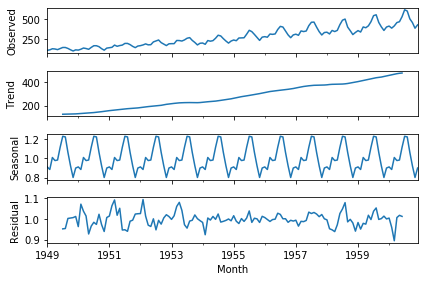

In [125]:
result = seasonal_decompose(airline['Thousands of Passengers'], model = 'multiplicative')
type(result)

result.plot()
plt.show()

-------------
-------------

# ARIMA

### Notes:
1. Two types: seasonal VS non-seasonal
2. Apply context: where data show evidence of non-stationarity ==> initial differencing step can be applied one/more times to eliminate this non-stationarity

### 3 Components:
1. ##### AR: utilize dependency between a current observaiton & observations over a previous period
2. ##### I: differencing of observations
3. ##### MA: utilize dependency between an observation & a residual error from a MA model applied to lagged observations

### Stationary data:
1. Check: mean, variance(波动大小), covariance(波动频率)
2. Test: Dickey-Fuller Test
3. Transform: Differencing till stationary
    * For seasonal data, can difference by season:
        * e.g. for monthly data with yearly seasonality, can difference by a time unit of 12 instead of 1.
    * Another common tech: take seasonal difference of the 1st difference
4. After make sure stationary: choose p, d, q values

### ACF & PACF
1. ACF, 2 common plots: gradual decline VS sharp drop-off